In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from helpers.physics_functions import get_bins
from helpers.evaluation import get_median_percentiles



from rikabplotlib.plot_utils import newplot, hist_with_outline, hist_with_errors, function_with_band, stamp
# from helpers.plotting import newplot, hist_with_outline, hist_with_errors, function_with_band, stamp
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Try to load LaTeX
latex_flag = True
np.seterr(divide='ignore')

# try:
#     plt.rc('text', usetex=True)
#     plt.rc('font', family='serif')
#     fig, ax = newplot("full", use_tex = True)
#     print("Loaded LaTeX")
#     latex_flag = True
# except:
#     print("Could not load LaTeX")
#     latex_flag = False  
# latex_flag = False

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Setup

In [2]:
num_bins_SR = 12 # 16, 12, 8


def bkg_fit_cubic(x, a, b, c, d):
    return a + b*x + c*x**2 + d*x**3 

def bkg_fit_quintic(x, a, b, c, d, e, f):
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5

def bkg_fit_septic(x, a, b, c, d, e, f, g, h):
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5 + g*x**6 + h*x**7



pseudo_e_to_plot = 0 # this plots the actual data (not a boostrapped version)
fit_type = "quintic" # "cubic", "quintic", septic
if fit_type == "cubic": fit_function = bkg_fit_cubic
if fit_type == "quintic": fit_function = bkg_fit_quintic
if fit_type == "septic": fit_function = bkg_fit_septic

fit_degree = 5


# Define outut folder for plot data
plot_data_dir = f"plot_data/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 100
n_folds = 5
particle_type = "upsilon_iso"
particle_id = "upsilon"
ONE_SIDED = True


# Needed for Classical Studies
jet_id = "nojet"
config_id = "CATHODE_8"
project_id = "lowmass"
flow_id = "mix_2"
feature_set = ["dimu_pt", "mu0_ip3d", "mu1_ip3d"]


train_samesign = False


# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "_SS"
else:
    train_data_id = "_OS"

# train on opp sign means alt test set is samesign
if train_data_id == "": 
    alt_test_data_id = "_SS"
    train_data_id_title = "_OS"
elif train_data_id == "_SS": 
    alt_test_data_id = ""
    train_data_id_title = "_SS"

data_prefix = f"upsilon_OS"
data_prefix_SS = f"upsilon_SS"
print(data_prefix)

upsilon_OS


In [3]:
bin_percent = {8: 2.3, 12: 1.5, 16: 1.1}

In [4]:
with open(f"{plot_data_dir}lowmass_upsilon_iso_nojet_SR_SB.pickle", "rb") as file:
    SR, SB = pickle.load(file)
    SB_left, SB_right = SB
    SR_left, SR_right = SR

print(f"SR: {SR_left}, {SR_right}")
print(f"SB: {SB_left}, {SB_right}")

SR: 9.0, 10.6
SB: 5.0, 16.0


In [5]:
with open(f"{plot_data_dir}{data_prefix}_SR_data_OS.pickle", "rb") as infile:
    isolation_data = pickle.load(infile)

# Cut Histograms

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np

# Color conversion filters
def rgb_to_gray(color):
    """Convert an RGB color to grayscale using luminosity."""
    return 0.2989 * color[0] + 0.5870 * color[1] + 0.1140 * color[2]

def rgb_to_rg_colorblind(color):
    """Convert an RGB color to a simulated red-green colorblind palette."""
    # Transformation matrix for RG colorblind simulation
    # Approximation for protanopia or deuteranopia
    colorblind_matrix = np.array([
        [0.567, 0.433, 0.0],
        [0.558, 0.442, 0.0],
        [0.0, 0.242, 0.758]
    ])
    return np.clip(np.dot(colorblind_matrix, color), 0, 1)

def apply_color_filter(color, filter_function):
    """General function to apply a filter to a color."""
    if isinstance(color, str):  # Convert named color to RGB
        color = mcolors.to_rgb(color)
    filtered_color = filter_function(color)
    if np.isscalar(filtered_color):  # Grayscale outputs a single value
        return (filtered_color, filtered_color, filtered_color)
    return tuple(filtered_color)

# Plot element updates
def update_lines(ax, filter_function):
    for line in ax.get_lines():
        color = line.get_color()
        new_color = apply_color_filter(color, filter_function)
        line.set_color(new_color)

def update_patches(ax, filter_function):
    for patch in ax.patches:
        face_color = patch.get_facecolor()
        edge_color = patch.get_edgecolor()
        new_face_color = apply_color_filter(face_color[:3], filter_function) + (face_color[3],)
        new_edge_color = apply_color_filter(edge_color[:3], filter_function) + (edge_color[3],)
        patch.set_facecolor(new_face_color)
        patch.set_edgecolor(new_edge_color)

def update_collections(ax, filter_function):
    for collection in ax.collections:
        face_colors = collection.get_facecolor()
        edge_colors = collection.get_edgecolor()
        if len(face_colors) > 0:
            new_face_colors = [
                apply_color_filter(fc[:3], filter_function) + (fc[3],) for fc in face_colors
            ]
            collection.set_facecolor(new_face_colors)
        if len(edge_colors) > 0:
            new_edge_colors = [
                apply_color_filter(ec[:3], filter_function) + (ec[3],) for ec in edge_colors
            ]
            collection.set_edgecolor(new_edge_colors)

def update_legend(ax, filter_function):
    legend = ax.get_legend()
    if legend:
        for text in legend.get_texts():
            text.set_color("black")  # Keep legend text black
        for handle in legend.legendHandles:
            if isinstance(handle, mpatches.Patch):  # Patches (e.g., histograms)
                face_color = handle.get_facecolor()
                edge_color = handle.get_edgecolor()
                new_face_color = apply_color_filter(face_color[:3], filter_function) + (face_color[3],)
                new_edge_color = apply_color_filter(edge_color[:3], filter_function) + (edge_color[3],)
                handle.set_facecolor(new_face_color)
                handle.set_edgecolor(new_edge_color)
            elif hasattr(handle, 'get_color'):  # Lines
                color = handle.get_color()
                new_color = apply_color_filter(color, filter_function)
                handle.set_color(new_color)

def apply_color_filter_to_plot(ax, filter_function):
    """Apply a color filter to all elements of a plot."""
    update_lines(ax, filter_function)
    update_patches(ax, filter_function)
    update_collections(ax, filter_function)
    update_legend(ax, filter_function)
    # Axes ticks and spines
    ax.tick_params(colors='black')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')

    return ax

In [7]:
def plot_upsilon_resonances(ax):

    
    # plot the upsilon resonances
    ax.axvline(9.460, color="black", linestyle="--", alpha=0.15, lw = 1.5)
    ax.text(9.460 * 0.995, 1e4, r"$\Upsilon(1S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=5)
    ax.axvline(10.023, color="black", linestyle="--", alpha=0.15, lw = 1.5)
    ax.text(10.023 * 0.995, 1e4, r"$\Upsilon(2S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=5)
    ax.axvline(10.355, color="black", linestyle="--", alpha=0.15, lw = 1.5)
    ax.text(10.355 * 0.995, 1e4, r"$\Upsilon(3S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=5)
    ax.axvline(10.580, color="black", linestyle="--", alpha=0.15, lw = 1.5)
    ax.text(10.580 * 0.995, 1e4, r"$\Upsilon(4S)$", rotation=90, verticalalignment="center", horizontalalignment="right", fontsize=5)


def plot_histograms_with_fits(save_data, SB_left, SR_left, SR_right, SB_right, title = None, upsilon_lines = True, colors = None, alphas = None, line_0 = None):
    
    num_points = 6

    fpr_thresholds = save_data["fpr_thresholds"]
    num_bins_SR = save_data["num_bins_SR"]
    popts = save_data["popts"]
    pcovs = save_data["pcovs"]
    significances = save_data["significances"]
    filtered_masses = save_data["filtered_masses"]
    y_vals = save_data["y_vals"]


    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


    fig, ax = newplot("column", width = 4, height = 4)


    if colors is None:
        colors = ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']
    if alphas is None:
        alphas = np.linspace(1, 0.5, len(fpr_thresholds))[::-1]

    # colors = [((i) * np.power(i, 0.25), 0 , (1-i) * np.power(i, 0.25)) for i in np.linspace(0, 1, len(fpr_thresholds))]

    # # plot the iso data
    # filtered_masses_iso = filtered_masses[-1]
    # popt_iso = popts[-1]
    # pcov_iso = pcovs[-1]
    # total_events_iso = len(filtered_masses_iso)
    # significance_iso = significances[-1]
    # y_vals_iso = y_vals[-1]

    # # plot the fit function
    # plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt_iso), lw = 2, linestyle = "dashed", color = "black")
    # function_with_band(ax, fit_function, [SB_left, SB_right], popt_iso, pcov_iso, color = "black", alpha_band = 0.2, alpha_line = 0.85, linestyle = "dashed", lw = 2)

    # # plot the data
    # label_string = r"Pre-Anti-Iso, $Z_0$: "+str(round(significance_iso,2))
    # # plt.hist(filtered_masses_iso, bins = plot_bins_all, lw = 3, histtype = "step", color = "black",label = label_string, alpha = 0.75)
    # hist_with_outline(ax, filtered_masses_iso, bins = plot_bins_all, range = (SB_left, SB_right), color = "black", label = label_string, alpha_1 = 0.005, lw = 1.5, alpha_2 = 0.75)
    



    
    for t, threshold in enumerate(fpr_thresholds):

        if t % 2 == 1:
            continue
        
        filtered_masses_t = filtered_masses[t]
        popt = popts[t]
        pcov = pcovs[t]
        total_events = len(filtered_masses_t)
        significance = significances[t]
        y_vals_t = y_vals[t]

        print(plot_centers_SB.shape, y_vals_t.shape)
        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = colors[t])    
        function_with_band(ax, fit_function, [SB_left, SB_right], popt, pcov, color = colors[t], alpha_band = 0.2, alpha_line = 0.85, linestyle = "dashed", lw = 2)

        # plot the data
        label_string = str(round(100*threshold, 2))+r"\%, $Z_0$: "+str(round(significance,2))
        # plt.hist(filtered_masses_t, bins = plot_bins_all, lw = 3, histtype = "step", color = colors[t],label = label_string, alpha = 0.75)
        hist_with_outline(ax, filtered_masses_t, bins = plot_bins_all, range = (SB_left, SB_right), color = colors[t], label = label_string, alpha_1 = 0.005, lw = 1.5, alpha_2 = alphas[t])
        # plt.scatter(plot_centers_SB, y_vals_t, color = colors[t], alpha = 0.5)




    line1 = r"16.4fb$^{-1}$"
    line2 = r"$\sqrt{s} = 13$ TeV"
    line3 = r"Anti-Isolated"
    line4 = r""

    starting_x = 0.0500
    starting_y = 0.95
    delta_y = 0.055
    text_alpha = 0.75

    if line_0 is not None:
        # ax.text(starting_x, starting_y - (-1) * delta_y, r"$\texttt{HLT\_TrkMu15\_DoubleTrkMu5NoFiltersNoVt}$", transform=ax.transAxes, fontsize=7, verticalalignment='top', alpha = text_alpha)
        ax.text(starting_x, starting_y - (0) * delta_y, line_0, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 1 * delta_y, line1, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 2 * delta_y, line2, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 3 * delta_y, line3, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha)
    ax.text(starting_x, starting_y - 4 * delta_y, line4, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha)


    legend_title = title
    # plt.legend(loc = (0.485, 0.575), fontsize = 9, title = legend_title, title_fontsize = 11)
    plt.legend(loc = "upper right", fontsize = 9, title = "False Positive Rate", title_fontsize = 10)
    plt.title(title, fontsize = 10, loc = "right")


    plt.axvline(SR_left, color= "k", lw = 1.5, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 1.5, zorder = 10)

    plt.xlabel("Dimuon Mass $m_{\mu\mu}$ [GeV]")
    plt.ylabel("Events",)

    plt.yscale("log")
    # plt.ylim(0.5, 1e3)
    plt.xlim(SB_left, SB_right)
    plt.ylim(0.01, 1e5)

    # Add more x ticks (major and minor)
    plt.xticks()
    plt.yticks()
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

    if upsilon_lines:
        plot_upsilon_resonances(ax)

    return fig, ax

    # apply_color_filter_to_plot(ax, rgb_to_gray)
    # apply_color_filter_to_plot(ax, rgb_to_rg_colorblind)
        

File to open:  plot_data/lowmass_upsilon_iso_OS_nojet_histogram_data_5_12.pickle
File to open:  plot_data/upsilon_OS_histogram_data_5_12.pickle
(64,) (64,)
(64,) (64,)
(64,) (64,)
(64,) (64,)
(64,) (64,)
(64,) (64,)
(64,) (64,)
(64,) (64,)
(64,) (64,)
(64,) (64,)
(64,) (64,)
(64,) (64,)


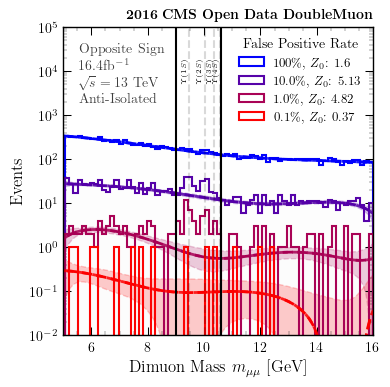

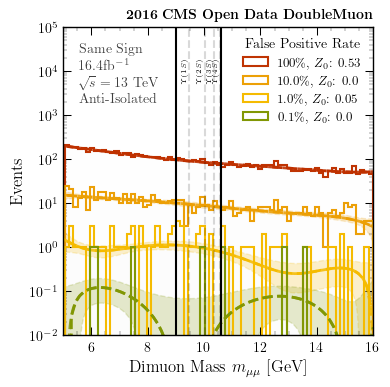

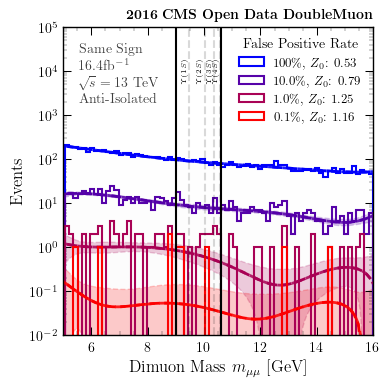

In [8]:


num_points = 7
bsx_c = [((0.99 * i) * np.power(i, 0), 0 , 0.99*(1-i) * np.power(i, 0.0)) for i in np.linspace(0, 1, num_points)]
bsx_a = np.linspace(0.99, 0.99, num_points)

# Red Yellow Green color scheme
# 8ea604-c2b102-f5bb00-f1ad03-ec9f05-d76a03-bf3100
ryg_c = ['#6A7D04', '#758904', "#819704", "#c2b102", "#f5bb00", "#f1ad03", "#ec9f05", "#d76a03", "#bf3100"][::-1]
ryg_a = np.linspace(0.99, 1, num_points)


# Plot the CATHODE
print("File to open: ", f"plot_data/lowmass_upsilon_iso_OS_nojet_histogram_data_{fit_degree}_12.pickle")
print("File to open: ", f"{plot_data_dir}{data_prefix}_histogram_data_{fit_degree}_{num_bins_SR}.pickle")
with open(f"{plot_data_dir}{data_prefix}_histogram_data_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    hist_data = pickle.load(file)
fig, ax = plot_histograms_with_fits(hist_data, SB_left, SR_left, SR_right, SB_right, title = r"$\bf{ 2016\,\, CMS\,\, Open\,\, Data\,\, DoubleMuon}$", upsilon_lines = True, colors = bsx_c, alphas = bsx_a, line_0 = r"Opposite Sign")
# apply_color_filter_to_plot(ax, rgb_to_gray)
# apply_color_filter_to_plot(ax, rgb_to_rg_colorblind)
plt.savefig(f"plots/histogram_{fit_type}_{num_bins_SR}.pdf", bbox_inches = "tight")

# Plot the Same Sign VALIDATION CATHODE
with open(f"{plot_data_dir}{data_prefix}_histogram_data_alt_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    hist_data_alt = pickle.load(file)
fig, ax = plot_histograms_with_fits(hist_data_alt, SB_left, SR_left, SR_right, SB_right, title = r"$\bf{ 2016\,\, CMS\,\, Open\,\, Data\,\, DoubleMuon}$", upsilon_lines = True, colors = ryg_c, alphas = ryg_a, line_0 = r"Same Sign")
# apply_color_filter_to_plot(ax, rgb_to_gray)
plt.savefig(f"plots/histogram_alt_{fit_type}_{num_bins_SR}.pdf", bbox_inches = "tight")




# # Plot the Same Sign  CATHODE
with open(f"{plot_data_dir}{data_prefix_SS}_histogram_data_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    hist_data_SS = pickle.load(file)
fig, ax = plot_histograms_with_fits(hist_data_SS, SB_left, SR_left, SR_right, SB_right, title = r"$\bf{ 2016\,\, CMS\,\, Open\,\, Data\,\, DoubleMuon}$", upsilon_lines = True, colors = bsx_c, alphas = bsx_a, line_0 = r"Same Sign")
plt.savefig(f"plots/histogram_SS_{fit_type}_{num_bins_SR}.pdf", bbox_inches = "tight")

# # Plot the individual features
# for feature in feature_set:
#     with open(f"{plot_data_dir}{data_prefix}_feature_cut_data_{feature}_{fit_type}_{num_bins_SR}.pickle", "rb") as file:
#         hist_data = pickle.load(file)

#     plot_histograms_with_fits(hist_data, SB_left, SR_left, SR_right, SB_right, title = r"$\bf{ 2016\,\, CMS\,\, Open\,\, Data\,\,(\mu^+\mu^-)}$: " + feature, upsilon_lines = True)


# Feature Histograms

In [9]:
with open(f"{plot_data_dir}{data_prefix}_feature_data_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    feature_data = pickle.load(file)

In [10]:
def plot_features(save_data, colors, alphas):

    num_points = 7
    fpr_thresholds = save_data["fpr_thresholds"]
    filtered_features_all = save_data["features"]


    n_features = len(feature_set) 
    nbins = 35

    bins = {
        "dimu_pt": np.linspace(0, 150, nbins),
        "mu0_ip3d": np.logspace(-4, 0, nbins),
        "mu1_ip3d": np.logspace(-4, 0, nbins),
    }
    labels = {
        "dimu_pt": "Dimuon $p_T$ [GeV]",
        "mu0_ip3d": "Harder Mu IP3D [cm]",
        "mu1_ip3d": "Softer Mu IP3D [cm]",
    }

    




    
    fig, ax = newplot("column", width = 9, height = 3, subplot_array=(1, n_features))
    # fig, ax = plt.subplots(1, n_features, figsize = (9, 3))

    # Plot the iso data
    for i_feat in range(n_features):

        feature = isolation_data[feature_set[i_feat]]
        label_string = "Pre Anti-Isolation Cut"

        ax[i_feat].hist( feature, bins=bins[feature_set[i_feat]], lw = 1.5, histtype = "step", color = "black",label = label_string, alpha = 0.75)
        ax[i_feat].hist( feature, bins=bins[feature_set[i_feat]], lw = 1.5, histtype = "stepfilled", color = "black", alpha = 0.25)
        

    
    for t, threshold in enumerate(fpr_thresholds[:num_points]):

        if t % 2 == 1:
            continue

        filtered_features = filtered_features_all[t]
        
   
        for i_feat in range(n_features):

            label_string = str(round(100*threshold, 2))+"\% FPR"

            white_color = (np.array([4, 4, 4]) + colors[t])/5
            

            ax[i_feat].hist( filtered_features[i_feat], bins=bins[feature_set[i_feat]], lw = 1.5, histtype = "step", color = colors[t],label = label_string, alpha = alphas[t])
            ax[i_feat].hist( filtered_features[i_feat], bins=bins[feature_set[i_feat]], lw = 1.5, histtype = "stepfilled", color = white_color, alpha = 0.99)
            ax[i_feat].set_yscale("log")

            if i_feat == 0:
                ax[i_feat].set_xlim(10, 150)
                ax[i_feat].set_xticks([0, 50, 100, 150])

            if i_feat in [1, 2]:
                ax[i_feat].set_xscale("log")
                ax[i_feat].set_xticks([1e-3, 1e-2, 1e-1])
            ax[i_feat].set_xlabel(labels[feature_set[i_feat]])
            ax[i_feat].set_ylim(5e-1, 5e4)

            ax[i_feat].tick_params()

            if i_feat > 0:
                ax[i_feat].set_yticklabels([])

    starting_x = 0.075
    starting_y = 0.955
    delta_y = 0.05
    text_alpha = 0.75

    line0 = r"Opposite Sign: $\mu^+\mu^-$"
    line1 = f"Bin width = {bin_percent[num_bins_SR]}\%"
    line2 = f"Fit Type: {fit_type.capitalize()}"
    line3 = r"Muon Iso_04 $\geq$ 0.55"
    line4 = r"16.4fb$^{-1}$, $\sqrt{s} = 13$ TeV"

    if line0 is not None:
        ax[1].text(starting_x, starting_y - (0) * delta_y, r"$\texttt{HLT\_TrkMu15\_DoubleTrkMu5NoFiltersNoVt}$", transform=ax[1].transAxes, fontsize=7, verticalalignment='top', alpha = text_alpha, zorder = 10)
        ax[1].text(starting_x, starting_y - (1) * delta_y, line0, transform=ax[1].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)

    ax[2].text(starting_x, starting_y - 0 * delta_y, line1, transform=ax[2].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax[2].text(starting_x, starting_y - 1 * delta_y, line2, transform=ax[2].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax[2].text(starting_x, starting_y - 2 * delta_y, line3, transform=ax[2].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax[2].text(starting_x, starting_y - 3 * delta_y, line4, transform=ax[2].transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)

    title = r"$\bf{ 2016\,\, CMS\,\, Open\,\, Data\,\, DoubleMuon}$"
    plt.title(title, fontsize = 10, loc = "right")
           

    legend_title = r"Upsilon Resonances: Iso, Opp. Sign"
    ax[0].legend(loc = "upper right", fontsize = 8)

    ax[0].set_ylabel("Events")
    plt.subplots_adjust(wspace=0)



    return save_data
    
    

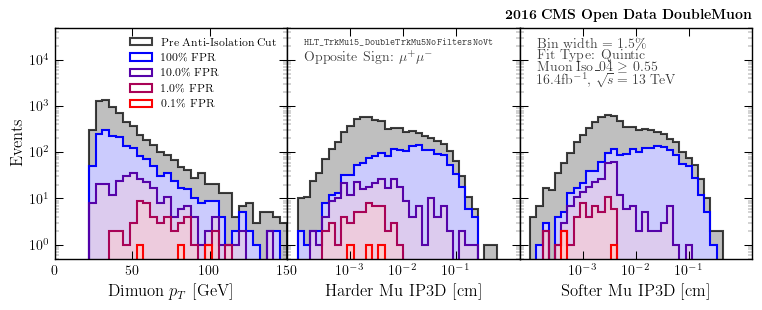

In [11]:
feature_data = plot_features(feature_data, bsx_c, bsx_a)
plt.savefig(f"plots/features_{fit_type}_{num_bins_SR}.pdf", bbox_inches = "tight")

# Significances 

In [12]:
fpr_thresholds_finegrained = np.logspace(-3, 0, 25)[::-1]

feature_sigs = {}
random_sigs = {}

for feature in feature_set:
    with open(f"{plot_data_dir}{data_prefix}_significances_{feature}_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
        feature_sigs[feature] = pickle.load(file)


with open(f"{plot_data_dir}{data_prefix}_significances_random_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    random_sigs = pickle.load(file)


with open(f"{plot_data_dir}{data_prefix}_significances_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    feature_sigs["CATHODE"] = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix}_full_q0_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    full_q0  = pickle.load(file)

# Get alt
feature_sigs_alt = {}
random_sigs_alt = {}

for feature in feature_set:
    with open(f"{plot_data_dir}{data_prefix}_significances_alt_{feature}_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
        feature_sigs_alt[feature] = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix}_significances_alt_random_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    random_sigs_alt = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix}_significances_alt_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    feature_sigs_alt["CATHODE"] = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix}_full_q0_alt_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    full_q0_alt  = pickle.load(file)
full_q0_alt = None

# Get SS
feature_sigs_SS = {}
random_sigs_SS = {}

for feature in feature_set:
    with open(f"{plot_data_dir}{data_prefix_SS}_significances_{feature}_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
        feature_sigs_SS[feature] = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix_SS}_significances_random_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    random_sigs_SS = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix_SS}_significances_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    feature_sigs_SS["CATHODE"] = pickle.load(file)

with open(f"{plot_data_dir}{data_prefix_SS}_full_q0_{fit_degree}_{num_bins_SR}.pickle", "rb") as file:
    full_q0_SS  = pickle.load(file)

    

In [13]:
import matplotlib.patches as mpatches
from scipy.stats import norm


def get_median_percentiles(x_array):
    
    x_median = np.median(x_array, axis = 1)
    x_lower = np.percentile(x_array, 16, axis = 1)
    x_upper = np.percentile(x_array, 84, axis = 1)

    x_2lower = np.percentile(x_array, 2.5, axis = 1)
    x_2upper = np.percentile(x_array, 97.5, axis = 1)

    return x_median, x_lower, x_upper, x_2lower, x_2upper


def inverse_quantile(sigma):

    return 1 - norm.cdf(sigma)


print(inverse_quantile([0, 1, 2, 3, 4, 5]))

def plot_sig(feature_sigs, random_sigs, ymax = 10, ymin = 1e-15, bonus = None):


    # FPR Variant of SIC
    fig, ax = newplot("column",width = 4, height = 4)

    primary_colors = ["red", "orange", "green", "blue"]
    colors = ["lightcoral", "gold", "lime", "cornflowerblue"]


    min_x = 2e-4
    labels = {"CATHODE" : r"CATHODE", "dimu_pt" : "Dimuon $p_T$", "mu0_ip3d" : "Harder Mu IP3D", "mu1_ip3d" : "Softer Mu IP3D"}


    # primary_colors = ["red",  "blue"]
    # colors = ["lightcoral",  "cornflowerblue"]

    for (i, key) in enumerate(["dimu_pt", "mu1_ip3d", "mu0_ip3d", "CATHODE",]):


        # SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(feature_sigs[key][:,1:])
        SIG_observed = feature_sigs[key][:,0]
        p_values = inverse_quantile(SIG_observed)

        ax.plot(fpr_thresholds_finegrained, p_values, color = primary_colors[i], lw = 3, alpha = 0.75, marker = "o", ms = 5, label = labels[key])
        ax.plot(fpr_thresholds_finegrained, p_values, color = primary_colors[i], lw = 0, alpha = 0.99, marker = "o", ms = 5,)


        # # Plot the maximum observed significance
        max_observed = np.nanmax(SIG_observed)
        # plt.scatter(min_x*1.05, max_observed, color = primary_colors[i], zorder = 1000, marker="*", s = 100)
        # plt.plot([min_x, min_x*3], [max_observed, max_observed], color = primary_colors[i], linestyle = "dashed", alpha = 0.5, lw = 1)
        # plt.text(min_x * 1.15, max_observed + 0.35, f"Max: {max_observed:.1f}$\sigma$", color = primary_colors[i], fontsize = 10, verticalalignment = "center")

        print(f"{key}: {max_observed}")



    # Plot the bonus
    if bonus is not None:
        p_value = inverse_quantile(bonus)
        plt.axhline(p_value, color = "purple", lw = 3, alpha = 0.75, ms = 3, label = r"Full Likelihood")


    # Plot the random cut
    # SIG_random_median, _, _ ,_ ,_ = get_median_percentiles(random_sigs[:,1:])
    SIG_random_observed = random_sigs[:,0]
    p_values = inverse_quantile(SIG_random_observed)
    plt.plot(fpr_thresholds_finegrained, p_values, color = "black", lw = 3, alpha = 0.75, marker = "o", ms = 5, label = "Random Cut")
    plt.plot(fpr_thresholds_finegrained, p_values, color = "black", lw = 0, alpha = 0.99, marker = "o", ms = 5)

    # # add text 
    # plt.text(min_x * 1.15, SIG_random_observed[0] + 0.35, f"Original: {SIG_random_observed[0]:.1f}$\sigma$", color = "black", fontsize = 10, verticalalignment = "center")


    print(feature_sigs["CATHODE"][:,0])



    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("Background-Only $p$-Value")

    plt.yscale("log")

    line_0 = r"Opposite Sign Muons"
    if ymax < 10:
        line_0 = r"Same Sign Muons"

        
    line1 = f"Bin width = {bin_percent[num_bins_SR]}\%"
    line2 = f"Fit Type: {fit_type.capitalize()}"
    line3 = r"Muon Iso_04 $\geq$ 0.55"
    line4 = r"16.4fb$^{-1}$, $\sqrt{s} = 13$ TeV"

    starting_x = 0.050
    starting_y = 0.25
    delta_y = 0.05
    text_alpha = 0.75

    if line_0 is not None:
        ax.text(starting_x, starting_y - (-1.5) * delta_y, r"$\texttt{HLT\_TrkMu15\_DoubleTrkMu5NoFiltersNoVt}$", transform=ax.transAxes, fontsize=5, verticalalignment='top', alpha = text_alpha, zorder = 10)
        ax.text(starting_x, starting_y - (-1) * delta_y, line_0, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)

    ax.text(starting_x, starting_y - 0 * delta_y, line1, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax.text(starting_x, starting_y - 1 * delta_y, line2, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax.text(starting_x, starting_y - 2 * delta_y, line3, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)
    ax.text(starting_x, starting_y - 3 * delta_y, line4, transform=ax.transAxes, fontsize=10, verticalalignment='top', alpha = text_alpha, zorder = 10)


    legend_title = r"$\bf{2016\,\, CMS\,\, Open\,\, Data\,\, DoubleMuon}$"
    plt.legend(loc = "lower right", ncol = 1, fontsize = 9)    
    plt.title(legend_title, loc = "right", fontsize = 10)

    # thin vertical line at 1e-4
    plt.axvline(1e-4, color = "grey", linestyle = "dashed", alpha = 0.5, lw = 1)


    # Plot sigmas
    i = 0
    while inverse_quantile(i) > ymin:
        p_value = inverse_quantile(i)
        plt.axhline(p_value, color = "grey", linestyle = "dashed", alpha = 0.5, lw = 1)

        if i > 0 and inverse_quantile(i+1) > ymin:
            plt.text(3e-4, p_value * 1.5, f"{i}$\sigma$", fontsize = 10, verticalalignment = "center")

        # fill above
        plt.fill_between([min_x, 1], p_value, 0.5, color = "grey", alpha = 0.025)

        i += 1

    # plt.legend(title = legend_title, loc = "upper center", ncol = 2, fontsize = 14)
    plt.xscale("log")
    plt.ylim(ymin, 0.5)
    plt.xlim(min_x, 1)
    # plt.yscale("log")

    # ax.plot(FPR_median, SIC_median, color = "black", label = r"CATHODE")
    # ax.fill_between(FPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = "black")
    # ax.plot(FPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey", label = "Random Cut")
    # ax.set_xlabel("FPR")
    # ax.set_ylabel("Signifance Improvement")

    # legend_title = "Original Signifiance = {###}"
    # plt.legend(title = legend_title, loc = "upper right")
    # plt.xscale("log")
    # plt.ylim(0, 6)

    return fig, ax

    plt.savefig(f"plots/significance_{fit_type}_{num_bins_SR}.pdf")



[5.00000000e-01 1.58655254e-01 2.27501319e-02 1.34989803e-03
 3.16712418e-05 2.86651572e-07]


dimu_pt: 3.1293626304432953
mu1_ip3d: 3.530235666808067
mu0_ip3d: 4.125542021540008
CATHODE: 5.74325371288894
[1.59558023 2.24223024 2.87517824 3.20379185 3.18098953 3.3474562
 4.18922443 5.48218307 5.12614931 5.74325371 4.14415231 4.82796079
 4.88739602 5.55225173 5.43519286 3.81564899 4.81595798 4.54599964
 3.34339601 3.35751683 2.00003067 1.83495721 0.43243236 0.25770322
 0.36962906]
dimu_pt: 1.6624577534900513
mu1_ip3d: 2.1439536765921514
mu0_ip3d: 2.1614176705765167
CATHODE: 1.3024556267637803
[0.526288   0.56353757 0.64914855 0.20652614 0.65599758 0.26775032
 1.04198648 1.30245563 0.         0.3630581  0.17734072 0.18744957
 0.4630619  0.36292655 0.44456077 0.         0.05011977 1.0695181
 0.         0.09591709 0.06440445 0.         0.         0.78107788
 0.        ]
dimu_pt: 1.6624577534900513
mu1_ip3d: 2.1439536765921514
mu0_ip3d: 2.1614176705765167
CATHODE: 2.2624820118956332
[0.526288   0.71705351 0.7192471  0.48417019 0.56164242 0.92831264
 1.35342571 0.41702352 0.78752915 0

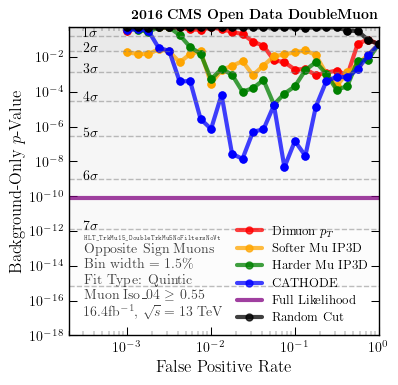

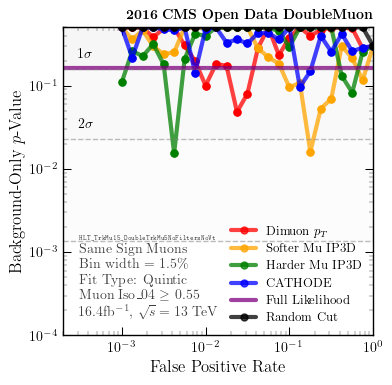

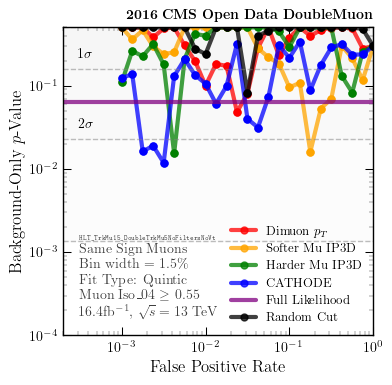

In [14]:
fig, ax = plot_sig(feature_sigs, random_sigs, bonus = 6.39, ymin = 1e-18)
plt.savefig(f"plots/significance_{fit_type}_{num_bins_SR}.pdf", bbox_inches = "tight")


fig, ax = plot_sig(feature_sigs_alt, random_sigs_alt, ymax = 5, ymin=1e-4, bonus = 0.98)
plt.savefig(f"plots/significance_alt_{fit_type}_{num_bins_SR}.pdf", bbox_inches = "tight")

fig, ax = plot_sig(feature_sigs_SS, random_sigs_SS, ymax = 5, ymin=1e-4, bonus =  1.53)
plt.savefig(f"plots/significance_SS_{fit_type}_{num_bins_SR}.pdf", bbox_inches = "tight")

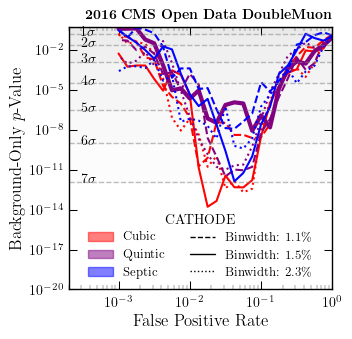

In [ ]:
def plot_variations():

    fig, ax = newplot("column")


    fits = ["cubic", "quintic", "septic"]
    degrees = [3, 5, 7]
    colors = ["red", "purple", "blue"]
    linestyles = ["dashed", "solid", "dotted"]
    bins = [8, 12, 16]
    percentages = [1.1, 1.5, 2.3]

    for i, fit in enumerate(fits):
        for (j, bin) in enumerate(bins):
           with open(f"{plot_data_dir}{data_prefix}_significances_{degrees[i]}_{bin}.pickle", "rb") as file:
                sigs = pickle.load(file)

                # SIG_median, SIG_lower, SIG_upper, SIG_2lower, SIG_2upper = get_median_percentiles(sigs[:,1:])
                SIG_observed = sigs[:,0]
                p_values = inverse_quantile(SIG_observed)

                
                label = f"Deg. {degrees[i]}, {bin} bins"

                if i == 1 and j == 1:
                    linewidth = 3

                else:
                    linewidth = 1.5

                ax.plot(fpr_thresholds_finegrained, p_values, color = colors[i], alpha = 0.99, ls = linestyles[j], label = label, lw = linewidth)


                # # if i == 1 and j == 1, plot the lower and upper bounds
                # if i == 1 and j == 1:
                #     ax.fill_between(fpr_thresholds_finegrained, SIG_lower, SIG_upper, alpha = 0.1, color = "grey")
                #     ax.fill_between(fpr_thresholds_finegrained, SIG_2lower, SIG_2upper, alpha = 0.1, color = "grey")

                #     # plot the boundaries with a thin line
                #     ax.plot(fpr_thresholds_finegrained, SIG_lower, color = "grey", linestyle = linestyles[j], alpha = 0.5, lw = 0.5)
                #     ax.plot(fpr_thresholds_finegrained, SIG_upper, color = "grey", linestyle = linestyles[j], alpha = 0.5, lw = 0.5)

                #     ax.plot(fpr_thresholds_finegrained, SIG_2lower, color = "grey", linestyle = linestyles[j], alpha = 0.5, lw = 0.5)
                #     ax.plot(fpr_thresholds_finegrained, SIG_2upper, color = "grey", linestyle = linestyles[j], alpha = 0.5, lw = 0.5)

    plt.xscale("log")
    plt.xlabel("False Positive Rate")
    plt.ylabel(r"Background-Only $p$-Value")

    ymin = 1e-20
    for i in range(7+1):

        p_value = inverse_quantile(i)
        plt.axhline(p_value, color = "grey", linestyle = "dashed", alpha = 0.5, lw = 1)

        if i > 0 and inverse_quantile(i+1) > ymin:
            plt.text(3e-4, p_value * 1.5, f"{i}$\sigma$", fontsize = 10, verticalalignment = "center")

        # fill above
        plt.fill_between([2e-4, 1], p_value, 0.5, color = "grey", alpha = 0.025)


    plt.yscale("log")

    # Make a fake 2 column legend: Column 1 is red-purple-blue for the fits, Column 2 is dashed-dotted-solid for the bins
    legend_items = []
    for i, fit in enumerate(fits):
        legend_item = mpatches.Patch(label=fit.capitalize(), edgecolor=colors[i], facecolor=colors[i], alpha = 0.5)
        legend_items.append(legend_item)

    # # Legend item for the grey band
    # legend_item = mpatches.Patch(label="Quintic, 11 bins $\pm$ 1, 2$\sigma$", edgecolor="grey", facecolor="grey", linestyle = "--", alpha = 0.5)
    # legend_items.append(legend_item)


    # Make lines for the bins, not rectange
    for j, bin in enumerate(bins):
        legend_item = plt.Line2D([0], [0], color='black', lw=1, linestyle = linestyles[j], label=f"Binwidth: {percentages[j]}\%")
        legend_items.append(legend_item)


    plt.legend(handles=legend_items, loc = "lower center", ncol = 2, fontsize = 9, columnspacing=2, title = "CATHODE", title_fontsize = 10)
    plt.title(r"$\bf{2016\,\, CMS\,\, Open\,\, Data\,\, DoubleMuon}$", loc = "right", fontsize = 10)

    plt.ylim(1e-20, 0.5)
    plt.xlim(2e-4, 1)
            
plot_variations()

plt.savefig(f"plots/significance_variations.pdf")